# (PART) DATA EXPLORATION {-}
# How do you create a GWAS project directory ready for analysis?

## Explanation  
Before working with data, it's important to set up a clean and organized project directory. A consistent folder structure helps you manage scripts, datasets, and outputs across both Python and R — making your work easier to follow and share.

In this guide, we’ll create a root directory called `gwas-data-science` with four folders:

- `data/` – for datasets  
- `scripts/` – for code files  
- `images/` – for plots and charts  
- `library/` – for reusable functions  

---

**Example Folder Structure:**

```plaintext
gwas-data-science/
├── data/
├── scripts/
├── images/
└── library/
```

---


## Bash (Terminal)

You can create the entire structure using this single command:

```bash
mkdir -p gwas-data-science/{data,scripts,images,library}
cd gwas-data-science
```

## Python Code

You can also create the same folder structure in Python:


```python
import os

folders = ["data", "scripts", "images", "library"]
root = "gwas-data-science"

os.makedirs(root, exist_ok=True)
for folder in folders:
    os.makedirs(os.path.join(root, folder), exist_ok=True)

print(f"Created '{root}' project folder with subdirectories.")
```

## R Code

Here’s how to do it in R:

```R
folders <- c("data", "scripts", "images", "library")
root <- "gwas-data-science"

if (!dir.exists(root)) dir.create(root)
for (folder in folders) {
  dir.create(file.path(root, folder), showWarnings = FALSE)
}

cat("Created", root, "project folder with subdirectories.\n")
```

> ✅ A clean project directory helps you stay organized, reuse code, and avoid errors — it’s the first step toward reproducible, professional data science.



## Import libraries

```{r}
library(tidyverse)
library(rrBLUP)
library(BGLR)
library(DT)
library(SNPRelate)
library(qqman)
library(poolr)
```

# How do you prepare a public GWAS dataset for R-based analysis?

## Explanation

To support reproducible and cross-platform workflows, it's helpful to separate raw data preparation from your analysis code. In this example, we use a Bash script to download and organize a publicly available rice diversity panel dataset from [Zhao et al., 2011](http://ricediversity.org/data/sets/44kgwas/).

The script performs the following steps:

- 📥 Downloads PLINK-formatted genotype files (`.ped`, `.map`, `.fam`)  
- 📦 Unzips and flattens the directory structure for easy access  
- 🏷️ Renames the phenotype file for clarity (`sativas413_phenotypes.txt`)  
- 📁 Moves all outputs into a consistent `data/` directory with a `sativa413_` prefix

This setup creates a clean and well-organized foundation for downstream R-based GWAS analysis.

## Bash Script

```bash
#!/bin/bash

# 🚀 Prepare rice GWAS genotype and phenotype data (PLINK format)

# --- Paths and filenames ---
ZIP_URL="http://ricediversity.org/data/sets/44kgwas/RiceDiversity.44K.MSU6.Genotypes_PLINK.zip"
ZIP_FILE="data/rice_gwas_genotypes.zip"
EXTRACT_DIR="data/RiceDiversity_44K_Genotypes_PLINK"
PHENO_URL="http://www.ricediversity.org/data/sets/44kgwas/RiceDiversity_44K_Phenotypes_34traits_PLINK.txt"
PHENO_OUT="data/sativas413_phenotypes.txt"

# --- Step 1: Ensure data folder exists ---
mkdir -p data

# --- Step 2: Download genotype zip file (if not already present) ---
if [ ! -f "$ZIP_FILE" ]; then
  echo "⬇️ Downloading genotype data..."
  wget --no-check-certificate -O "$ZIP_FILE" "$ZIP_URL"
else
  echo "✅ Genotype zip already exists: $ZIP_FILE"
fi

# --- Step 3: Unzip genotype data ---
echo "📂 Extracting genotype files..."
unzip -o "$ZIP_FILE" -d data/

# --- Step 4: Move files up and clean nested folder ---
if [ -d "$EXTRACT_DIR" ]; then
  mv "$EXTRACT_DIR"/* data/
  rm -rf "$EXTRACT_DIR"
fi
rm -rf data/__MACOSX
rm -f "$ZIP_FILE"

# --- Step 5: Download phenotype file and rename ---
echo "⬇️ Downloading phenotype file..."
wget --no-check-certificate -P data/ "$PHENO_URL"
mv data/RiceDiversity_44K_Phenotypes_34traits_PLINK.txt "$PHENO_OUT"

echo "✅ GWAS data successfully prepared in the data/ folder."
```

The Bash script is saved as:  

```bash
script/gwas_data.sh
```

To run it:

```bash
bash script/gwas_data.sh
```

## File Structure
After execution, the `data/` folder contains:

```
project/
├── script/
│   └── gwas_data.sh
└── data/
    ├── sativa413.map
    ├── sativa413.ped
    ├── sativa413.fam
    └── sativas413_phenotypes.txt
```

> ✅ **Takeaway:** Using a Bash script to automate dataset download and organization keeps your R analysis environment clean, standardized, and fully reproducible. All required files are now available in the `data/` folder under the `sativa413_` prefix.

# How do you efficiently load and store GWAS data files in R?

## Explanation

GWAS datasets can be large, especially the genotype file in `.ped` format, which stores two columns per SNP. Repeatedly reading this file is time-consuming, so it’s best to:

- Load it once using `readr::read_table()` for speed and consistency.
- Save the loaded object as a compressed `.rds` file for fast future access.
- Load supporting metadata files (`.map`, `.fam`) and phenotype data using consistent column names.

All files are stored in the `data/` directory and prefixed with `sativa413_`.

## R Code

```{r}
library(tidyverse)

# Step 1: Load genotype data using readr
ped_data <- read_table("data/sativas413.ped", col_names = FALSE, show_col_types = FALSE)

# Step 2: Save as compressed RDS file
write_rds(ped_data, file = "data/sativas413.rds")

# Step 3: Load metadata files
map_data <- read_table("data/sativas413.map", 
                       col_names = c("chr", "snp_id", "gen_dist", "bp_pos"), 
                       show_col_types = FALSE)

fam_data <- read_table("data/sativas413.fam", 
                       col_names = c("FID", "IID", "PID", "MID", "sex", "phenotype"), 
                       show_col_types = FALSE)

phenotype_data <- read_tsv("data/sativas413_phenotypes.txt", show_col_types = FALSE)
```

> ✅ **Takeaway:** For large genotype files, load once using `readr`, save as `.rds`, and always use clear column names when importing metadata and phenotype files to streamline analysis and ensure reproducibility.

# How do you inspect the structure and contents of GWAS input files in R?

## Explanation

Before analysis, it’s essential to preview each file to check:

- Row and column dimensions
- Sample ID consistency
- General format of genotype and phenotype data

This ensures everything is aligned before tidying or merging.

## R Code

```{r}
# Load genotype file (if needed)
ped_data <- read_rds("data/sativas413.rds")

# Check size of each file
dim(ped_data)         # Genotype matrix
dim(map_data)         # SNP metadata
dim(fam_data)         # Sample info
dim(phenotype_data)   # Trait info

# Preview first few rows and columns
head(ped_data[, 1:5])        # First 5 genotype columns (show alleles)
head(map_data)
head(fam_data[, 1:5])
head(phenotype_data[, 1:5])
```

> ✅ **Takeaway:** Use `dim()` and `head()` to quickly check file structure and confirm that samples and traits align before transforming or analyzing GWAS data.

# How do you tidy the genotype matrix from a `.ped` file in R?

## Explanation

PLINK `.ped` files store genotype data in a wide format, where each SNP is represented by **two columns per individual** (one for each allele). This structure is inefficient for downstream analysis, so we convert it to a **tidy format** where:

- Each row represents one sample
- Each column represents one SNP
- Alleles are combined (e.g., `"A A"`, `"A G"`, `"G G"`)

We also use SNP metadata from the `.map` file — now consistently referred to as `snp_info` — to label the columns.

## R Code

```{r}
# Load necessary library
library(tidyverse)

# Step 1: Load genotype and SNP info (if not already in memory)
ped_data <- read_rds("data/sativas413.rds")
snp_info <- read_table("data/sativas413.map", 
                       col_names = c("chr", "snp_id", "gen_dist", "bp_pos"), 
                       show_col_types = FALSE)

# Step 2: Separate sample IDs and genotype calls
sample_ids <- ped_data[, 1:2]              # FID and IID
genotype_matrix <- ped_data[, -(1:6)]      # Alleles only

# Step 3: Verify expected SNP count
n_snps <- ncol(genotype_matrix) / 2
stopifnot(n_snps == nrow(snp_info))

# Step 4: Combine each pair of allele columns into genotype strings
genotype_calls <- map_dfc(seq(1, ncol(genotype_matrix), by = 2), function(i) {
  paste(genotype_matrix[[i]], genotype_matrix[[i + 1]])
})
names(genotype_calls) <- snp_info$snp_id  # Use SNP IDs as column names

# Step 5: Combine with sample IDs
genotype_tidy <- bind_cols(sample_ids, genotype_calls)

# Step 6: Preview output
head(genotype_tidy[1:10, 1:5])  # Show FID, IID, and first 8 SNPs
glimpse(genotype_tidy[1:5, 1:10])  # Show FID, IID, and first 8 SNPs
```

> ✅ **Takeaway:** Tidying `.ped` genotype data into a clean sample-by-SNP format makes it much easier to analyze, visualize, or convert to numeric dosages. Use `snp_info` consistently as the SNP metadata reference to avoid conflicts.

# How do you recode allele strings into numeric count format for GWAS?

## Explanation

After tidying the `.ped` genotype matrix into a clean format where each SNP column contains values like `"A A"`, `"A G"`, or `"G G"`, most GWAS tools require those genotypes to be **numeric**:

> **Genotype count format:**  
> - `0` = Homozygous for major allele  
> - `1` = Heterozygous  
> - `2` = Homozygous for minor allele  
> - `NA` = Missing or uncalled genotype

To do this, we:

1. Identify the two alleles observed at each SNP  
2. Determine the **minor allele** (less frequent)  
3. Count how many copies of the **minor allele** each individual has (`0`, `1`, or `2`)

---

✅ **Clarifying the structure of the genotype matrix:**

Each pair of alleles (like `"A G"`, `"G G"`, `"T C"`) represents a **genotype** for a single SNP in a single individual.

So when you load the `.ped` file and separate it into allele pairs:

- **Each pair** = one **genotype**  
- **Each column** = one **SNP**  
- **Each row** = one **sample**

> 🧠 This distinction is important when converting genotype strings to numeric formats for GWAS.

## R Code

```{r}
# Load libraries
library(tidyverse)

# Step 1: Drop FID and IID from genotype_tidy to isolate genotype columns
geno_alleles <- genotype_tidy[, -c(1, 2)]

# Step 2: Convert allele strings to numeric minor allele counts
geno_minor_allele_count <- map_dfc(geno_alleles, function(allele_vec) {
  # Split all genotype strings (e.g., "A G") into individual alleles
  alleles <- unlist(str_split(allele_vec, " "))
  allele_counts <- table(alleles)

  # Skip SNPs that are monomorphic or malformed
  if (length(allele_counts) < 2) return(rep(NA, length(allele_vec)))

  # Identify the minor allele (less frequent)
  minor_allele <- names(sort(allele_counts))[1]

  # Count how many copies of the minor allele are in each genotype
  sapply(allele_vec, function(gt) {
    if (gt %in% c("0 0", "0 1", "1 0", "1 1", "0", "1")) return(NA)  # filter malformed
    split_alleles <- unlist(str_split(gt, " "))
    if (length(split_alleles) != 2) return(NA)
    sum(split_alleles == minor_allele)
  })
})

# Step 3: Add back sample identifiers
genotype_count <- bind_cols(genotype_tidy[, 1:2], geno_minor_allele_count)

# Step 4: Preview the cleaned matrix
glimpse(genotype_count[, 1:5])
```

> ✅ **Takeaway:** Recoding genotype strings into numeric dosages (0, 1, 2) is essential for statistical GWAS models. It standardizes input and prepares your data for PCA, association testing, or genomic prediction.

# How do you filter SNPs and samples based on missing data and minor allele frequency?
<!-- # How do you filter genotype data for missingness and minor allele frequency? -->

## Explanation

Before running GWAS, it's important to apply basic quality control (QC) to the genotype matrix. This ensures that:

- SNPs with too many missing genotypes are excluded  
- SNPs with very low variability (low minor allele frequency) are removed  
- Samples with excessive missing data (optional) are filtered out  

These steps improve statistical power and reduce false associations.

## R Code

```{r}
# Load required libraries
library(tidyverse)

# Step 1: Remove sample columns (FID, IID)
count_only <- genotype_count[, -c(1, 2)]

# Step 2: Filter SNPs by missingness (e.g., keep SNPs with <10% missing values)
snp_missing <- colMeans(is.na(count_only))
snp_keep <- names(snp_missing[snp_missing < 0.1])
filtered_count <- count_only[, snp_keep]

# Step 3: Filter SNPs by minor allele frequency (MAF >= 0.05)
calc_maf <- function(x) {
  p <- mean(x, na.rm = TRUE) / 2
  min(p, 1 - p)
}
snp_maf <- map_dbl(filtered_count, calc_maf)
maf_keep <- names(snp_maf[snp_maf >= 0.05])
final_count <- filtered_count[, maf_keep]

# Step 4: Reattach FID and IID
filtered_geno <- bind_cols(genotype_count[, 1:2], final_count)

# Step 5: Summary of filtering
cat("Original SNPs:", ncol(count_only), "\n")
cat("After missing filter:", length(snp_keep), "\n")
cat("After MAF filter:", length(maf_keep), "\n")
```

> ✅ **Takeaway:** Apply SNP-level filters for missing data and low MAF to improve data quality. This ensures that only informative and reliable markers are used in your GWAS analysis.

# How do you impute missing genotype values before GWAS analysis?

## Explanation

Many GWAS and population structure methods (like PCA or kinship matrix computation) require complete genotype matrices. If you have filtered for missingness but still have a few `NA` values, a simple approach is to impute missing genotypes using the **mean dosage** for each SNP.

This is fast, reproducible, and good enough for visualization and many linear models.

## R Code

```{r}
# Load library
library(tidyverse)

# Step 1: Extract dosage matrix (without FID/IID)
dosage_matrix <- filtered_geno[, -c(1, 2)]

# Step 2: Impute missing values using column means
imputed_matrix <- dosage_matrix %>%
  mutate(across(everything(), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .)))

# Step 3: Add back FID and IID
geno_imputed <- bind_cols(filtered_geno[, 1:2], imputed_matrix)

# Step 4: Preview
head(geno_imputed[, 1:5])
glimpse(geno_imputed[1:5, 1:10])
```

> ✅ **Takeaway:** Simple mean imputation fills missing genotype values efficiently. It’s suitable for PCA, kinship, and linear models when high accuracy isn't critical or when advanced imputation isn't available.

# How do you perform PCA on genotype data to assess population structure?

## Explanation

PCA (Principal Component Analysis) is a standard method to explore genetic diversity and detect hidden population structure in GWAS datasets. It helps:

- Control for confounding due to stratification  
- Visualize sample clusters or outliers  
- Generate covariates (`PC1`, `PC2`, etc.) for use in association models

We apply PCA on the **imputed genotype dosage matrix**, excluding identifier columns (`FID`, `IID`), and then combine the results with sample IDs.

## R Code

```{r}
# Load libraries
library(tidyverse)

# Step 1: Extract genotype matrix (exclude FID and IID)
geno_numeric <- geno_imputed[, -c(1, 2)]

# Step 2: Perform PCA using prcomp
pca_result <- prcomp(geno_numeric, center = TRUE, scale. = TRUE)

# Step 3: Combine first 5 PCs with sample IDs
pca_df <- geno_imputed[, 1:2] %>%  # FID and IID
  bind_cols(as_tibble(pca_result$x[, 1:5]))  # PC1 to PC5

# Step 4: Plot PC1 vs PC2
ggplot(pca_df, aes(x = PC1, y = PC2)) +
  geom_point(size = 2, alpha = 0.7) +
  labs(title = "PCA of Genotype Data", x = "PC1", y = "PC2") +
  theme_minimal()
```

> ✅ **Takeaway:** PCA helps uncover hidden structure in your GWAS population. Always reattach `FID` and `IID` to PCA scores so they can be merged with phenotype and genotype metadata for downstream modeling.

# How do you include PCA covariates in a GWAS model?

## Explanation

To reduce false positives caused by hidden genetic structure, it's standard in GWAS to include the top principal components (PCs) as covariates in the model. These PCs come from PCA applied to the genotype matrix and must be matched back to each sample using the same identifiers (`FID`, `IID`).

This Q&A walks through the process of combining phenotype, PCA, and genotype data, then fitting a single SNP-trait association model.

## R Code

```{r}
# Load libraries
library(tidyverse)

# Step 1: Load and align phenotype data with sample metadata (by FID)
fam_data <- read_table("data/sativas413.fam", 
                       col_names = c("FID", "IID", "PID", "MID", "sex", "phenotype"), 
                       show_col_types = FALSE)

phenotype_data <- read_tsv("data/sativas413_phenotypes.txt", show_col_types = FALSE) %>%
  rename(FID = 1)  # Sample IDs in phenotype file match fam_data$FID

sample_metadata <- left_join(fam_data, phenotype_data, by = "FID")

# Step 2: Rename PCA columns to include proper IDs
pca_df <- pca_df %>%
  rename(FID = 1, IID = 2)

# Step 3: Merge PCA data into sample metadata
sample_data <- left_join(sample_metadata, pca_df, by = c("FID", "IID"))

# Step 4: Standardize ID columns in genotype data
geno_imputed <- geno_imputed %>%
  rename(FID = 1, IID = 2)

# Step 5: Merge genotype with metadata
geno_data <- geno_imputed[, -1]  # Drop FID, keep IID and SNPs
gwas_input <- left_join(sample_data, geno_data, by = "IID")

# Step 6: Select trait and covariates
trait <- "Plant height"  # Use the column name as a string
covariates <- c("PC1", "PC2", "PC3")

# Save the merged GWAS input to an RDS file for future use
saveRDS(gwas_input, file = "data/gwas_input.rds")

# Step 7: Construct the model formula
snp_name <- names(geno_data)[2]  # Replace with desired SNP
formula_str <- paste0("`", trait, "` ~ ", snp_name, " + ", paste(covariates, collapse = " + "))
model <- lm(as.formula(formula_str), data = gwas_input)

# Step 8: View model summary
summary(model)
```

> ✅ **Takeaway:** Always ensure PCA scores include correctly labeled `FID` and `IID` so they can be merged with metadata and genotype matrices before fitting GWAS models.

# How do you interpret GWAS model results with PCA covariates?

## Explanation

Once a GWAS model is fitted using a phenotype (e.g., *Plant height*), a SNP, and population structure covariates (e.g., PC1–PC3), we interpret the results using the model summary. The key values to look for are:

- **Estimate**: The effect size of each variable  
- **Pr(>|t|)**: The *p-value*, used to determine significance  
- **R-squared**: The proportion of variation in the trait explained by the model  
- **Residuals**: The spread of errors not explained by the model  

This example tests the association between SNP `id1000007` and *Plant height*, adjusting for PC1 to PC3.

## R Model Output Summary

| Coefficient   | Estimate  | Std. Error | t value | Pr(>|t|)  | Significance |
|:---------------|:-----------|:------------|:---------|:-----------|:--------------|
| (Intercept)   | 115.83448 | 1.04707    | 110.63  | < 2e-16   | ***          |
| id1000007     | 2.17767   | 1.54100    | 1.413   | 0.158     |              |
| PC1           | 0.20502   | 0.02761    | 7.426   | 7.49e-13  | ***          |
| PC2           | -0.19534  | 0.04436    | -4.404  | 1.39e-05  | ***          |
| PC3           | -0.29738  | 0.07399    | -4.019  | 7.05e-05  | ***          |

**Model Fit:**

- Residual standard error: **18.63**
- Degrees of freedom: **378**
- R-squared: **0.2277**
- Adjusted R-squared: **0.2195**
- F-statistic: **27.86 on 4 and 378 DF**
- Overall p-value: **< 2.2e-16**

> ✅ **Takeaway:** This SNP is not significant (`p = 0.158`), but PCs show strong association with plant height. Controlling for population structure is essential to avoid false signals in GWAS.

# (PART) GWAS ANALYSIS & VIZ {-}

# How do you perform a genome-wide SNP scan to generate GWAS results?

## Explanation

Once you’ve merged your phenotype, PCA covariates, and genotype matrix into a single data frame (`gwas_input`), you can perform a **genome-wide association scan**.

This involves fitting a linear model for each SNP, adjusting for population structure (e.g., PCs), and extracting the **effect size** and **p-value** for each SNP. These results are saved in a table for downstream visualization using Manhattan or QQ plots.

Each model looks like:

*Plant height ~ PC1 + PC2 + PC3 + SNP_i*

We loop over all SNP columns in the dataset that match known prefixes (`id`, `ud`, `wd`, `dd`, `fd`) and collect the outputs.

## R Code

```{r}
# Load required package
library(tidyverse)

# Step 1: Identify SNP columns using prefix pattern
snp_cols <- grep("^(id|ud|wd|dd|fd)[0-9]+$", names(gwas_input), value = TRUE)

# Step 2: Check number of SNPs selected
length(snp_cols)      # Should return 3755
head(snp_cols, 5)     # Preview first 5 SNPs

# Step 3: Initialize list to collect GWAS results
gwas_results <- list()

# Step 4: Loop over each SNP and fit linear model
for (snp in snp_cols) {
  # Construct formula dynamically
  formula <- as.formula(paste("`Plant height` ~ PC1 + PC2 + PC3 +", snp))
  
  # Fit model safely
  model <- tryCatch(
    lm(formula, data = gwas_input),
    error = function(e) NULL
  )
  
  # Step 5: If successful, extract coefficient and p-value
  if (!is.null(model)) {
    coef_table <- summary(model)$coefficients
    snp_row <- tail(rownames(coef_table), 1)
    
    gwas_results[[snp]] <- tibble(
      SNP = snp,
      Estimate = coef_table[snp_row, "Estimate"],
      P_value = coef_table[snp_row, "Pr(>|t|)"]
    )
  }
}

# Step 6: Combine results and sort by p-value
gwas_df <- bind_rows(gwas_results) %>%
  arrange(P_value)

# Step 7: Save the GWAS results for visualization
write_csv(gwas_df, "data/gwas_results.csv")

# Step 8: Preview top hits
head(gwas_df, 10)
```

> ✅ Takeaway: This loop scans 3,755 SNPs genome-wide and outputs a clean summary table with effect sizes and p-values — ready for visualization using Manhattan and QQ plots.

# How do you create a Manhattan plot from GWAS results using the `ggplot2` package?

## Explanation

A Manhattan plot visualizes the results of a genome-wide association study (GWAS) by plotting each SNP’s chromosomal position against the –log10(p-value) of its association with a trait. High peaks represent SNPs with strong associations.

To create a Manhattan plot using the `ggplot2` package:

- You must first merge the GWAS result table with SNP position data (e.g., from a `.map` file).
- The –log10(p-value) is computed to scale the plot.
- Cumulative genomic positions are calculated to plot SNPs across chromosomes on a continuous axis.
- Alternating colors help visually separate chromosomes.

## R Code

```{r}
# Load required libraries
library(tidyverse)

# Step 1: Load GWAS results and SNP position data
gwas_df <- read_csv("data/gwas_results.csv")
map_df <- read_tsv("data/sativas413.map", 
                   col_names = c("CHR", "SNP", "GEN_DIST", "BP_POS"),
                   show_col_types = FALSE)

# Step 2: Merge GWAS results with chromosome position
gwas_annotated <- left_join(gwas_df, map_df, by = "SNP") %>%
  drop_na()  # Remove SNPs with missing position

# Step 3: Compute cumulative position for plotting across chromosomes
gwas_annotated <- gwas_annotated %>%
  arrange(CHR, BP_POS) %>%
  group_by(CHR) %>%
  mutate(BP_CUM = BP_POS + ifelse(row_number() == 1, 0, lag(cumsum(BP_POS), default = 0))) %>%
  ungroup()

# Step 4: Compute –log10(p-value) and color group
gwas_annotated <- gwas_annotated %>%
  mutate(logP = -log10(P_value),
         CHR = as.factor(CHR),
         color_group = as.integer(CHR) %% 2)

# Step 5: Plot Manhattan plot
ggplot(gwas_annotated, aes(x = BP_CUM, y = logP, color = as.factor(color_group))) +
  geom_point(alpha = 0.7, size = 1.2) +
  scale_color_manual(values = c("#003b4a", "dodgerblue")) +
  labs(title = "Manhattan Plot Using ggplot2",
       x = "Genomic Position", y = expression(-log[10](p))) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "none",
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank())
```



> ✅ Takeaway: The ggplot2 package allows full control over layout, color, and formatting when visualizing SNP–trait associations across the genome in a Manhattan plot.

# How do you create a Manhattan plot from GWAS results using the `qqman` package?

## Explanation

The `qqman` package provides a convenient way to create Manhattan plots directly from GWAS result tables. A Manhattan plot displays each SNP's –log10(p-value) along its genomic position, helping identify regions with strong associations.

The function `manhattan()` expects a data frame with these key columns:

- `CHR`: Chromosome number  
- `BP`: Base-pair position  
- `SNP`: SNP identifier  
- `P`: P-value from the association test

You can prepare this by merging your GWAS result table with a `.map` file containing SNP positions.



## R Code

```{r}
# Load required libraries
library(tidyverse)
library(qqman)

# Step 1: Load GWAS results
gwas_df <- read_csv("data/gwas_results.csv")

# Step 2: Load SNP position data (.map file)
map_df <- read_tsv("data/sativas413.map", 
                   col_names = c("CHR", "SNP", "GEN_DIST", "BP"),
                   show_col_types = FALSE)

# Step 3: Merge results with map data
gwas_annotated <- left_join(gwas_df, map_df, by = "SNP") %>%
  select(SNP, CHR, BP, P = P_value) %>%
  drop_na()

# Step 4: Create Manhattan plot using qqman
manhattan(gwas_annotated,
          main = "Manhattan Plot of GWAS Results",
          col = c("grey30", "dodgerblue"),
          cex = 0.6,
          cex.axis = 0.9,
          las = 1)
```

> ✅ Takeaway: The qqman package offers a fast and simple way to create publication-ready Manhattan plots by plotting –log10(p-values) across the genome using SNP coordinates.

# How do you create a QQ plot from GWAS results using `qqman` and `ggplot2`?

## Explanation

A QQ (quantile–quantile) plot compares the distribution of observed p-values from a GWAS with the expected distribution under the null hypothesis. It is a diagnostic tool to detect population structure, inflation, or true associations.

You can use:

- ✅ `qqman::qq()` for a fast and simple plot  
- ✅ `ggplot2` for customization and control over styling and annotations

Both approaches produce a similar result but are suited to different use cases.

---



## A. Using the `qqman` package

```{r}
# Load required libraries
library(tidyverse)
library(qqman)

# Step 1: Load GWAS results
gwas_df <- read_csv("data/gwas_results.csv")

# Step 2: Create QQ plot using qqman
qq(gwas_df$P_value,
   main = "QQ Plot of GWAS Results (qqman)")
```

> 🟢 Simple and fast, but limited in customization (no legend or theming)




## B. Using `ggplot2` for more control

```{r}
# Load required library
library(tidyverse)

# Step 1: Load GWAS results
gwas_df <- read_csv("data/gwas_results.csv")

# Step 2: Calculate expected vs observed -log10(p)
gwas_df <- gwas_df %>%
  filter(!is.na(P_value)) %>%
  mutate(observed = -log10(sort(P_value)),
         expected = -log10(ppoints(n())))

# Step 3: Create QQ plot with reference line using ggplot2
ggplot(gwas_df, aes(x = expected, y = observed)) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  geom_point(size = 1.2, alpha = 0.6, color = "steelblue") +
  labs(title = "QQ Plot of GWAS Results (ggplot2)",
       x = "Expected -log10(p)",
       y = "Observed -log10(p)") +
  theme_minimal(base_size = 14)
```

> ✅ Takeaway: The red dashed line represents the expected distribution of p-values under the null hypothesis. Deviations above the line suggest potential true associations or population structure. Use qqman for simplicity or ggplot2 for full customization.

# How do you apply multiple testing correction to GWAS results?

## Explanation

In GWAS, thousands of SNPs are tested for association with a trait. This increases the chance of false positives. To control this, we apply **multiple testing correction** methods such as:

- **Bonferroni correction**: Very strict; divides the alpha level (e.g., 0.05) by the number of tests
- **False Discovery Rate (FDR)**: A more flexible method that controls the proportion of false positives among significant results (e.g., Benjamini-Hochberg)

This helps identify **statistically significant SNPs** while accounting for the large number of tests.

## R Code

```{r}
# Load required packages
library(tidyverse)

# Step 1: Load GWAS results
gwas_df <- read_csv("data/gwas_results.csv")

# Step 2: Add Bonferroni-corrected threshold
n_tests <- nrow(gwas_df)
bonf_threshold <- 0.05 / n_tests

# Step 3: Apply FDR correction using p.adjust
gwas_df <- gwas_df %>%
  mutate(FDR = p.adjust(P_value, method = "BH"))

# Step 4: Extract significant SNPs
significant_bonf <- gwas_df %>%
  filter(P_value < bonf_threshold)

significant_fdr <- gwas_df %>%
  filter(FDR < 0.05)

# Step 5: Output summary
cat("Bonferroni threshold:", bonf_threshold, "\n")
cat("Number of SNPs passing Bonferroni:", nrow(significant_bonf), "\n")
cat("Number of SNPs passing FDR < 0.05:", nrow(significant_fdr), "\n")
```

> ✅ Takeaway: Multiple testing correction is essential in GWAS. Bonferroni is strict but conservative, while FDR balances sensitivity and specificity. Always report how significance was determined.


## Interpretation

After applying multiple testing correction to the GWAS results:

- **Bonferroni threshold**: `1.331558e-05`  
  This is the genome-wide significance level calculated by:

*alpha_bonf = 0.05 / 3755 ≈ 1.33 × 10⁻⁵*


Any SNP with a raw p-value below this threshold is considered **highly significant**, even under the strictest correction method (controlling the family-wise error rate).

- **Number of SNPs passing Bonferroni**: `250`  
These are the **strongest associations**, with extremely low p-values. They're unlikely to be false positives and are good candidates for follow-up analysis or functional validation.

- **Number of SNPs passing FDR < 0.05**: `1265`  
These SNPs are considered statistically significant under a **False Discovery Rate (FDR) of 5%**. This means that, on average, only 5% of these hits are expected to be false positives. It’s a more permissive method that helps capture broader signals.

### Summary Table

| Correction Method | Threshold           | Significant SNPs | Interpretation                             |
|:-------------------|:---------------------|:------------------|:---------------------------------------------|
| Bonferroni        | `1.33e-05`          | 250              | Very strict; strong confidence              |
| FDR (BH)          | `adjusted < 0.05`   | 1265             | Balanced; allows more discovery, some risk  |

> ✅ **Takeaway:** Use Bonferroni to identify high-confidence SNPs and FDR to explore additional signals while controlling the expected proportion of false positives.

# How do you create a volcano plot from GWAS results using `ggplot2`?

## Explanation

A volcano plot is a powerful way to visualize both the **effect size** and **statistical significance** of SNPs in GWAS results. Each point represents a SNP, plotted by:

- **X-axis**: Effect size (regression coefficient)
- **Y-axis**: –log10(p-value), indicating significance

This plot highlights SNPs with:
- Large effect sizes
- Low p-values (high significance)
- Or both

You can also add horizontal and vertical reference lines to help interpret thresholds.

## R Code

```{r}
# Load required libraries
library(tidyverse)

# Step 1: Load GWAS results
gwas_df <- read_csv("data/gwas_results.csv")

# Step 2: Compute –log10(p-value)
gwas_df <- gwas_df %>%
  mutate(logP = -log10(P_value))

# Step 3: Create volcano plot
ggplot(gwas_df, aes(x = Estimate, y = logP)) +
  geom_point(alpha = 0.6, color = "grey40") +
  geom_hline(yintercept = -log10(0.05 / nrow(gwas_df)), linetype = "dashed", color = "red") +  # Bonferroni line
  geom_vline(xintercept = 0, linetype = "dotted", color = "black") +  # Null effect line
  labs(title = "Volcano Plot of GWAS Results",
       x = "Effect Size (Estimate)",
       y = expression(-log[10](p))) +
  theme_minimal(base_size = 14)


# Add significance status
gwas_df <- gwas_df %>%
  mutate(significant = P_value < 0.05 / nrow(gwas_df))

# Re-plot with color by significance
ggplot(gwas_df, aes(x = Estimate, y = logP, color = significant)) +
  geom_point(alpha = 0.7) +
  scale_color_manual(values = c("grey70", "red")) +
  geom_hline(yintercept = -log10(0.05 / nrow(gwas_df)), linetype = "dashed", color = "red") +
  geom_vline(xintercept = 0, linetype = "dotted", color = "black") +
  labs(title = "Volcano Plot with Bonferroni Threshold",
       x = "Effect Size (Estimate)",
       y = expression(-log[10](p))) +
  theme_minimal(base_size = 14) +
  theme(legend.title = element_blank())
```

> ✅ Takeaway: A volcano plot shows the balance between effect size and significance. SNPs with both large effects and low p-values appear as extreme points in the top left or right quadrants.

# How do you identify genome-wide significant SNP hits and save them for downstream analysis?

## Explanation

Once GWAS results are generated and corrected for multiple testing, the next step is to identify statistically significant SNPs. A common threshold is the **Bonferroni-adjusted p-value**, which accounts for the number of tests.

You can:

- Filter SNPs below the Bonferroni threshold
- Annotate them with chromosome and base-pair position using the `.map` file
- Save the output for use in downstream steps like gene annotation or reporting

## R Code

```{r}
# Load required libraries
library(tidyverse)

# Step 1: Load GWAS results
gwas_df <- read_csv("data/gwas_results.csv")

# Step 2: Calculate Bonferroni threshold
n_tests <- nrow(gwas_df)
bonf_threshold <- 0.05 / n_tests  # ≈ 1.33e-05 for 3755 SNPs

# Step 3: Filter significant hits
significant_hits <- gwas_df %>%
  filter(P_value < bonf_threshold) %>%
  arrange(P_value)

# Step 4: Load SNP position data
map_df <- read_tsv("data/sativas413.map",
                   col_names = c("CHR", "SNP", "GEN_DIST", "BP"),
                   show_col_types = FALSE)

# Step 5: Annotate significant SNPs with position
annotated_hits <- left_join(significant_hits, map_df, by = "SNP") %>%
  select(SNP, CHR, BP, Estimate, P_value)

# Step 6: Save for downstream analysis
write_csv(annotated_hits, "data/significant_snps_bonferroni.csv")

# Step 7: Preview top hits
head(annotated_hits, 10)
```

> ✅ Takeaway: Identifying and saving genome-wide significant SNPs ensures a clean input for downstream analysis such as gene annotation, pathway mapping, or publication reporting.


# How do you visualize significant SNPs from a Bonferroni-corrected GWAS results file?

## Explanation

After applying a Bonferroni correction in a GWAS analysis, we are left with a set of SNPs that meet a stringent significance threshold. Visualizing these SNPs helps identify genomic regions of interest and patterns of association. A common approach is to create a Manhattan-style scatter plot showing:

- **Chromosome (CHR)** or base pair position (BP) on the x-axis
- **–log₁₀(P-value)** on the y-axis to emphasize stronger associations
- Points optionally colored by chromosome for interpretability
- Labels for highly significant SNPs

This visualization provides a clear overview of which SNPs are driving the strongest signals in your study.

## Python Code




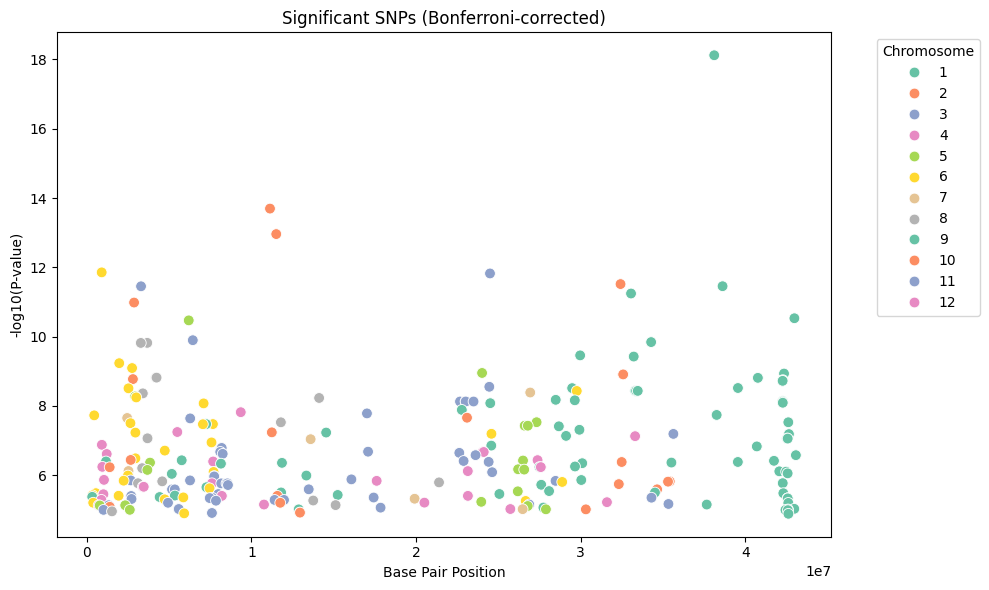

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the SNP data
snps = pd.read_csv("data/significant_snps_bonferroni.csv")

# Compute -log10(P-value)
snps["logP"] = -np.log10(snps["P_value"])

# Plot SNP significance by position and chromosome
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=snps,
    x="BP",
    y="logP",
    hue="CHR",
    palette="Set2",
    s=60
)

plt.title("Significant SNPs (Bonferroni-corrected)")
plt.xlabel("Base Pair Position")
plt.ylabel("-log10(P-value)")
plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## R Code

```{r}
# Load required packages
library(tidyverse)
library(ggrepel)

# Read the SNP data
snps <- read_csv("data/significant_snps_bonferroni.csv")

# Compute -log10(P-value)
snps <- snps %>%
  mutate(logP = -log10(P_value))

# Plot with chromosome coloring and labels for strong hits
ggplot(snps, aes(x = BP, y = logP, color = as.factor(CHR))) +
  geom_point(size = 3) +
  geom_text_repel(
    data = snps %>% filter(logP > 12),
    aes(label = SNP),
    size = 3
  ) +
  facet_wrap(~CHR, scales = "free_x") +
  labs(
    title = "Significant SNPs (Bonferroni-corrected)",
    x = "Base Pair Position",
    y = expression(-log[10](P-value)),
    color = "Chromosome"
  ) +
  theme_minimal()
```

> ✅ Takeaway: This visualization helps you inspect which SNPs reach genome-wide significance and how they are distributed across chromosomes. Labeling key hits adds insight into potential candidate loci.